In [2]:
import pandas as pd
import scanpy as sc
from scipy.io import mmread
from scipy import sparse
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import h5py
import csv
import os
import loompy
import anndata
from pandas import HDFStore
from sklearn.manifold import TSNE
import collections
import scipy.sparse as sp_sparse
import tables
import plotly.express as px
from sklearn.preprocessing import StandardScaler

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Data Loading

In [9]:
genes = pd.read_csv("../Data/Genes.csv")
barcode_positions = pd.read_csv("../Data/SpotPositions.csv")
tSNE_df = pd.read_csv("../Data/t-SNE-Projection.csv")

In [5]:
feature_matrix_precise = mmread("../Data/FeatureMatrix_precise.mtx")

In [19]:
adata = sc.read_10x_h5("../Data/Filtered_feature_bc_matrix.h5")

/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Data Display

In [23]:
genes

,gene,feature_type
0,Xkr4,Gene Expression
1,Gm1992,Gene Expression
2,Gm37381,Gene Expression
3,Rp1,Gene Expression
4,Sox17,Gene Expression
...,...,...
31048,AC168977.1,Gene Expression
31049,AC149090.1,Gene Expression
31050,CAAA01118383.1,Gene Expression
31051,Vmn2r122,Gene Expression


In [25]:
barcode_positions

,barcode,x,y,radius
0,AAACAAGTATCTCCCA-1,12709.0,10806.0,71.192911
1,AAACACCAATAACTGC-1,3616.0,12513.0,71.192911
2,AAACAGAGCGACTCCT-1,11839.0,3944.0,71.192911
3,AAACAGGGTCTATATT-1,2961.0,10225.0,71.192911
4,AAACATTTCCCGGATT-1,12159.0,12902.0,71.192911
...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,9974.0,7183.0,71.192911
3495,TTGTTTCACATCCAGG-1,6136.0,12325.0,71.192911
3496,TTGTTTCATTAGTCTA-1,4821.0,12705.0,71.192911
3497,TTGTTTCCATACAACT-1,4495.0,9846.0,71.192911


In [16]:
tSNE_df

,Barcode,X Coordinate,Y Coordinate
0,AAACAAGTATCTCCCA-1,7.170149,-6.169523
1,AAACACCAATAACTGC-1,-24.983043,-8.407789
2,AAACAGAGCGACTCCT-1,-12.087320,36.968580
3,AAACAGGGTCTATATT-1,-21.366652,-5.311882
4,AAACATTTCCCGGATT-1,11.085326,-17.753664
...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,35.546637,-23.506554
3495,TTGTTTCACATCCAGG-1,-3.515596,15.672737
3496,TTGTTTCATTAGTCTA-1,-20.753882,-5.643660
3497,TTGTTTCCATACAACT-1,-9.796795,22.895259


In [41]:
# TTGGATATCGTCTACG-1 and TGCGCCGTTAATAACG-1 index 
missing_cell_index1 = barcode_positions.index[barcode_positions['barcode'] == 'TTGGATATCGTCTACG-1'].tolist()[0]
missing_cell_index2 = barcode_positions.index[barcode_positions['barcode'] == 'TGCGCCGTTAATAACG-1'].tolist()[0]
print(missing_cell_index1, missing_cell_index2)


3463 3154


In [26]:
feature_matrix_precise

<31053x3499 sparse matrix of type '<class 'numpy.int64'>'
	with 13742662 stored elements in COOrdinate format>

## Data Processing

In [5]:
df_precise = pd.DataFrame.sparse.from_spmatrix(feature_matrix_precise)
df_precise.T

,0,1,2,3,4,5,6,7,8,9,...,31043,31044,31045,31046,31047,31048,31049,31050,31051,31052
0,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,2,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3495,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3497,0,0,0,0,0,0,3,0,0,3,...,0,0,0,0,0,0,1,0,0,0


In [6]:
df_precise = pd.DataFrame.sparse.from_spmatrix(feature_matrix_precise)

df_precise.columns = barcode_positions['barcode'].values
df_precise.index = genes['gene'].values

df_precise = df_precise.transpose()
df_precise.index.name = 'barcode'
df_precise

,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,Tcea1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
barcode,,,,,,,,,,,,,,,,,,,,,
AAACAAGTATCTCCCA-1,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACACCAATAACTGC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACAGAGCGACTCCT-1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,2,0,0,0
AAACAGGGTCTATATT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATTTCCCGGATT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
TTGTTTCACATCCAGG-1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
TTGTTTCATTAGTCTA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
showing = df_precise.iloc[0, :42]
df_display = pd.DataFrame([showing])
df_display.columns = range(1, 43)
df_display.T

,AAACAAGTATCTCCCA-1
1,0
2,0
3,0
4,0
5,0
6,0
7,2
8,0
9,0
10,0


In [24]:
tSNE_df.rename(columns={'X Coordinate': 'x', 'Y Coordinate': 'y', 'Barcode': 'barcode'}, inplace=True)
adata.var_names_make_unique()
umi_counts = adata.to_df()

total_counts = umi_counts.sum(axis=1)
cellTotal_df = pd.DataFrame(
    {"barcode": total_counts.index, "total_counts": total_counts.values}
)
cellTotal_df

,barcode,total_counts
0,AAACAAGTATCTCCCA-1,12174.0
1,AAACACCAATAACTGC-1,5637.0
2,AAACAGAGCGACTCCT-1,26316.0
3,AAACAGGGTCTATATT-1,6462.0
4,AAACATTTCCCGGATT-1,7195.0
...,...,...
3494,TTGTTGTGTGTCAAGA-1,6219.0
3495,TTGTTTCACATCCAGG-1,14493.0
3496,TTGTTTCATTAGTCTA-1,6621.0
3497,TTGTTTCCATACAACT-1,18042.0


In [25]:
cell_tsne_df = pd.merge(cellTotal_df, tSNE_df, on="barcode")
cell_tsne_df

,barcode,total_counts,x,y
0,AAACAAGTATCTCCCA-1,12174.0,7.170149,-6.169523
1,AAACACCAATAACTGC-1,5637.0,-24.983043,-8.407789
2,AAACAGAGCGACTCCT-1,26316.0,-12.087320,36.968580
3,AAACAGGGTCTATATT-1,6462.0,-21.366652,-5.311882
4,AAACATTTCCCGGATT-1,7195.0,11.085326,-17.753664
...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,6219.0,35.546637,-23.506554
3495,TTGTTTCACATCCAGG-1,14493.0,-3.515596,15.672737
3496,TTGTTTCATTAGTCTA-1,6621.0,-20.753882,-5.643660
3497,TTGTTTCCATACAACT-1,18042.0,-9.796795,22.895259


## Data Visualization

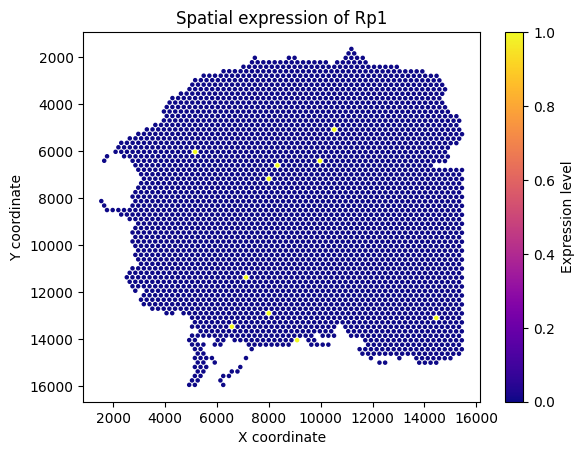

In [8]:
aligned_data = pd.merge(barcode_positions, df_precise, on='barcode')
aligned_data.drop(columns=['radius'], inplace=True)
gene_of_interest = "Rp1"

plt.scatter(
    aligned_data["x"],
    aligned_data["y"],
    c=aligned_data[gene_of_interest],
    cmap="plasma",
    s=5
)
plt.colorbar(label="Expression level")
plt.title(f"Spatial expression of {gene_of_interest}")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.gca().invert_yaxis()
plt.show()

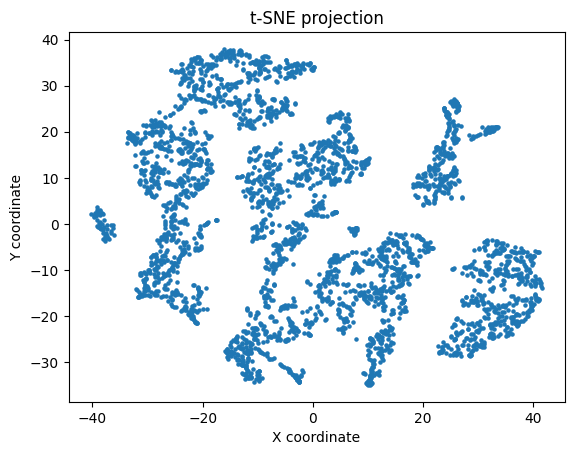

In [15]:
plt.scatter(
    tSNE_df["X Coordinate"],
    tSNE_df["Y Coordinate"],
    s=5
)
plt.title(f"t-SNE projection")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.show()